# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
import os
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import glob
import re
import geopandas as gpd


from urbanmask.urban_areas import (
    Urban_vicinity,
)

from urbanmask.UHI_plot_functions import (
    plot_climatology,
    plot_annual_cicle,
    plot_daily_cicle
)

from urbanmask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

In [2]:
city = 'Cordoba'
lon_city = -64.1888
lat_city = -31.4201

domain = 'CSAM-4i'
model = 'USP'
version = "v2"
scenario = "evaluation"

urban_th = 60
urban_sur_th = 1
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 3
lon_lim = 1
lat_lim = 1

urban_var = 'sftuf'

variable='tasmax'

Create a directory to save the results for this particular city and model

In [3]:
base_output_dir = 'results'
if model in ['NCAR', 'UCAN']:
    output_dir = f"{base_output_dir}/{city}-{domain}_{model}-WRF433-{version}"
elif model in ['USP']:
    output_dir = f"{base_output_dir}/{city}-{domain}_{model}-RegCM471-{version}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [4]:
domain_resolution = int( re.search(r'(\d+)', domain.split('-')[1]).group(1))
base_filename = f'{city}-{domain}_{model}-{version}_{scenario}_r1i1p1f1'
if model in ['NCAR', 'UCAN']:
    base_filename = f'{city}-{domain}_{model}-WRF433-{version}_{scenario}_r1i1p1f1'
elif model in ['USP']:
    base_filename = f'{city}-{domain}_{model}-RegCM471-{version}_{scenario}_r1i1p1f1'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [5]:
root = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/{domain}/{model}/*/evaluation/*/{model}-*/{version}/'

In [6]:
from shapely.geometry import box

def create_urban_dataset(ucdb_city, ds):
    '''
    Creates a dataset for urban areas where each cell value represents the percentage of the cell area
    that is within the city limits.

    Parameters:ssh-keygen -f "/home/yaizaquintana/.ssh/known_hosts" -R "ui.sci.unican.es"
    ucdb_city: GeoDataFrame containing the city's geometry.
    ds: Dataset from which we are extracting the coordinates.

    Returns:
        ds_urban: An xarray dataset with cells representing the percentage of urban area coverage.
    '''

    # Create a grid of latitude and longitude edges to define cell boundaries
    lon_grid, lat_grid = np.meshgrid(ds['lon'].values, ds['lat'].values)

    # Combine all geometries into a single geometry (in case there are multiple city polygons)
    city_geometry = ucdb_city.geometry.unary_union

    # Create an array to store the percentage of each cell covered by the city
    urban_data = np.zeros((ds['lat'].size, ds['lon'].size))

    # Calculate percentage for each cell
    for i in range(ds['lat'].size):
        for j in range(ds['lon'].size):
            # Define the boundaries of the cell as a polygon
            cell_poly = box(
                lon_grid[i, j] - 0.5 * np.diff(ds['lon'])[0],  # left
                lat_grid[i, j] - 0.5 * np.diff(ds['lat'])[0],  # bottom
                lon_grid[i, j] + 0.5 * np.diff(ds['lon'])[0],  # right
                lat_grid[i, j] + 0.5 * np.diff(ds['lat'])[0]   # top
            )

            # Calculate the area of intersection with the city geometry
            intersection_area = cell_poly.intersection(city_geometry).area
            cell_area = cell_poly.area

            # Calculate the percentage of the cell covered by the city
            urban_data[i, j] = (intersection_area / cell_area) * 100

    # Create the final xarray dataset containing the urban percentage information
    ds_urban = xr.Dataset(
        {
            'sftuf': (['lat', 'lon'], urban_data)
        },
        coords={
            'lat': ds['lat'],
            'lon': ds['lon'],
        }
    )
    
    return ds_urban

In [7]:
file_pattern = f'{root}fx/orog/orog_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_orog = xr.open_dataset(file_list[0], engine='netcdf4')

file_pattern = f'{root}fx/sftlf/sftlf_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_sftlf = xr.open_dataset(file_list[0], engine='netcdf4')

In [8]:
file_pattern = f'{root}fx/landuse/landuse_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_sftuf = xr.open_dataset(file_list[0], engine='netcdf4')
ds_sftuf['sftuf'] = (ds_sftuf['landuse'] == 13)*100

In [9]:
file_pattern = f'{root}fx/orog/orog_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_orog = xr.open_dataset(file_list[0], engine='netcdf4')

file_pattern = f'{root}fx/sftlf/sftlf_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_sftlf = xr.open_dataset(file_list[0], engine='netcdf4')

if model.startswith("USP") or model.startswith("ICTP"):
    #ucdb_info = gpd.read_file("/home/yaizaquintana/Desktop/DATA/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")
    ucdb_info = gpd.read_file('/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/GHS_FUA_UCD/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
    if city == 'PortoAlegre':
        ucdb_city = ucdb_info.query('UC_NM_MN == "Porto Alegre" ').to_crs(crs='EPSG:4326')
    elif city == 'BuenosAires':
        ucdb_city = ucdb_info.query('UC_NM_MN == "Buenos Aires" ').to_crs(crs='EPSG:4326')
    else:
        ucdb_city = ucdb_info.query('UC_NM_MN == @city').to_crs(crs='EPSG:4326')
    ds_sftuf = create_urban_dataset(ucdb_city, ds_orog)
else:
    file_pattern = f'{root}fx/landuse/landuse_{domain}_*.nc'
    file_list = glob.glob(file_pattern)
    ds_sftuf = xr.open_dataset(file_list[0], engine='netcdf4')
    ds_sftuf['sftuf'] = (ds_sftuf['landuse'] == 13)*100

/tmp/ipykernel_16342/1979411584.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_geometry = ucdb_city.geometry.unary_union


Add parameters to the function

In [10]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model,
    domain,
    urban_var)

Crop area around de city

In [11]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

Define masks using the parameters above

In [12]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [13]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

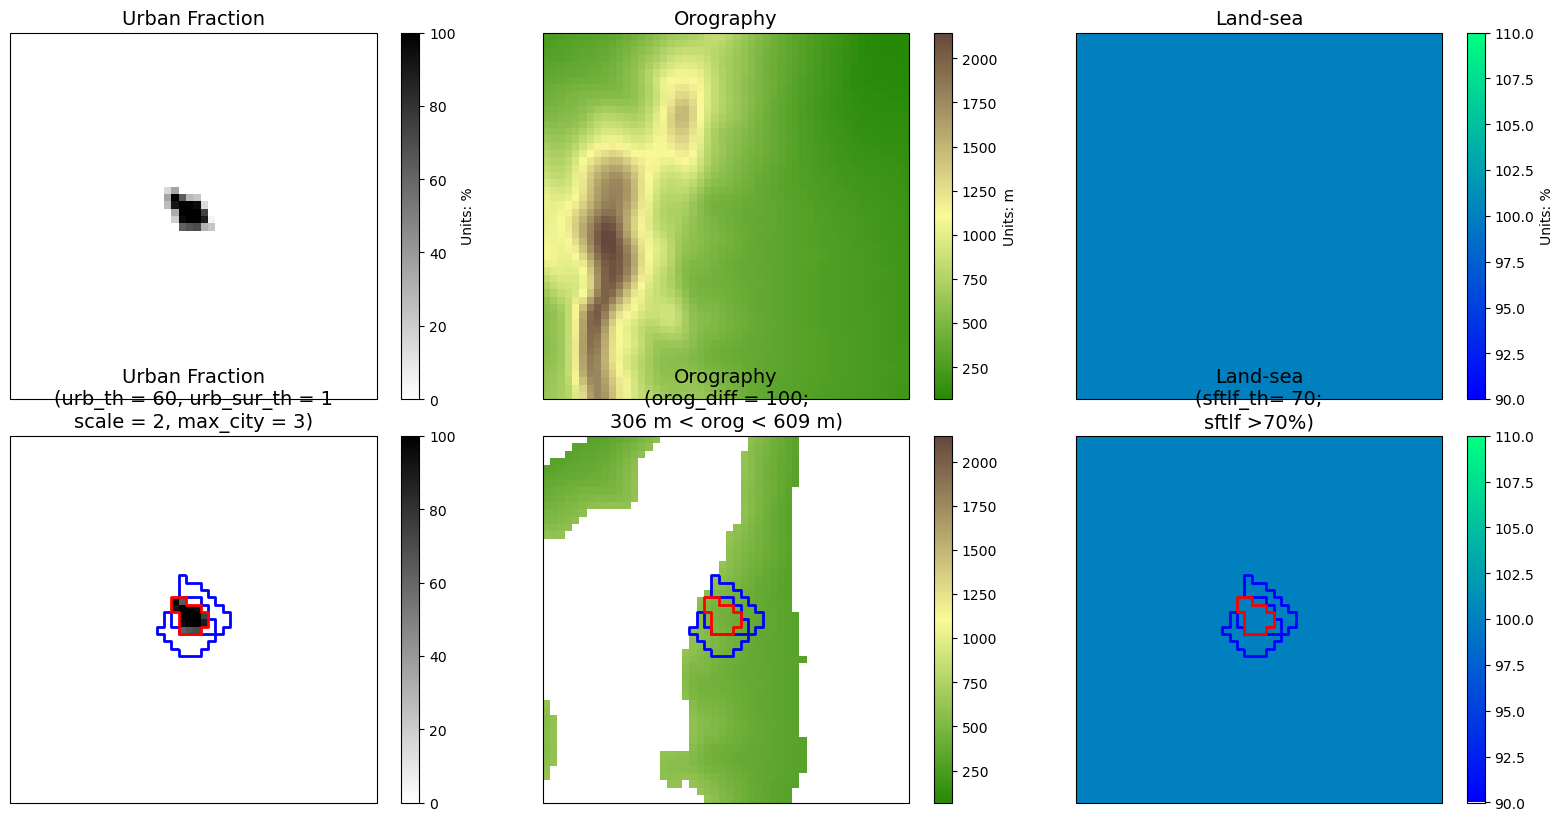

In [14]:
fig = URBAN.plot_static_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [15]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")
ds_sftuf.rename_vars({'sftuf': 'sfturf'}).to_netcdf(f"{output_dir}/sfturf_{base_filename}_fx.nc")

## Calculate urban heat island effect

### Load climate variable

In [16]:
file_pattern = f'{root}day/{variable}/*'
files = np.sort(glob.glob(file_pattern))
ds_RCM = xr.open_mfdataset(files, concat_dim='time', combine='nested')
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

### Calculate periods of heatwaves

In [17]:
is_urban = urmask['urmask'] == 1
urban_mean = (ds_RCM[variable]
    .where(is_urban)
    .mean(dim = [ds_RCM.cf['Y'].name, ds_RCM.cf['X'].name])
    .compute()
)

In [18]:
percentil_99 = urban_mean.quantile(0.99, dim='time')
exceedance = urban_mean > percentil_99
exceedance_times = urban_mean['time'].where(exceedance, drop=True)
exceedance_days = exceedance_times.dt.floor("D").values

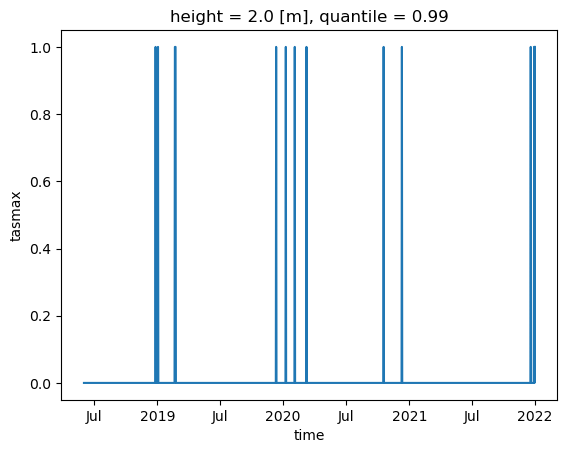

In [19]:
exceedance.plot()

In [20]:
import pandas as pd

df = pd.DataFrame({
    'city': city,
    'model': model,
    'version': version,
    'exceedance_times': exceedance_days
})
output_file= f"{base_output_dir}/heatwave.csv"
output_path = Path(output_file)
# Save CSV
if output_path.exists():
    df.to_csv(output_path, mode='a', header=False, index=False)
else:
    df.to_csv(output_path, mode='w', index=False)


In [21]:
variable= 'tas'

In [ ]:
if model.startswith('USP') and version == 'v1': #ICTP missing
    file_pattern = f'{root}3hr/{variable}/*'
else:
    file_pattern = f'{root}1hr/{variable}/*'
    
files = np.sort(glob.glob(file_pattern))
ds_RCM = xr.open_mfdataset(files, concat_dim='time', combine='nested')
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

In [ ]:
exceedance_days

In [ ]:
#ds_RCM_heatwave = ds_RCM.where(ds_RCM.time.dt.floor("D").isin(exceedance_days), drop=True)
ds_RCM_heatwave = ds_RCM.where(ds_RCM.time.dt.floor("D").isin(exceedance_days[5]), drop=True)

In [ ]:
cachefile = f"heatwaves_{city}/{variable}_{base_filename}_day_cycle_heatwaves_anomaly-ur.nc"

fig = plot_daily_cicle(variable, ds_RCM_heatwave,  urmask, 
    data_squares = True, city = city, cache= cachefile,period='Heatwaves', 
                       percentiles = [75,90])
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')

In [ ]:
cachefile = f"heatwaves_city/{variable}_{base_filename}_day_cycle_heatwaves-ur.nc"

fig = plot_daily_cicle(variable, ds_RCM_heatwave,  urmask, 
    data_squares = True, city = city, cache= cachefile,period='Heatwaves', annomaly= False
                       , percentiles = [75,90])
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')